In [6]:
import numpy as np
import librosa.display, os
import time

from torch import nn, optim
from torchsummary import summary
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cpu


In [13]:
def resample_audio(signal, sr, sampled_sr= 44100):
        if sr != sampled_sr:
            signal_resampled = librosa.resample(signal, orig_sr=sr, target_sr=sampled_sr)
            return signal_resampled, sampled_sr
        return signal, sr

def process_audio_duration(signal, sr, target_duration=5):
    # Make sure all audio are 5s
    target_samples = int(target_duration * sr)
    current_samples = len(signal)
    
    if current_samples > target_samples:
        signal = signal[:target_samples]
    
    # If the audio is shorter, pad with zeros (silence) to the target duration
    elif current_samples < target_samples:
        pad_length = target_samples - current_samples
        signal = np.pad(signal, (0, pad_length), mode='constant')
    
    return signal

def melspec_normalization(log_ms):
    # Normalize to [0, 1]
    return (log_ms - log_ms.min()) / (log_ms.max() - log_ms.min())
    
def load_audio(audio_file):
    y, sr = librosa.load(audio_file)
    y, sr = resample_audio(y, sr)
    # TO DO: should we add this?  reduce accuracy but looks better to compare spectrogram
    y = process_audio_duration(y,sr)
    y = librosa.util.normalize(y)
    return y,sr
    
def create_mel_spectrogram(audio_file):
    y, sr = load_audio(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    log_ms = melspec_normalization(log_ms)
    return log_ms, sr


def create_mel_spectrogram_image(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    log_ms, sr = create_mel_spectrogram(audio_file)

    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

    
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_mel_spectrogram_image(input_file, output_file)



/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)
/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


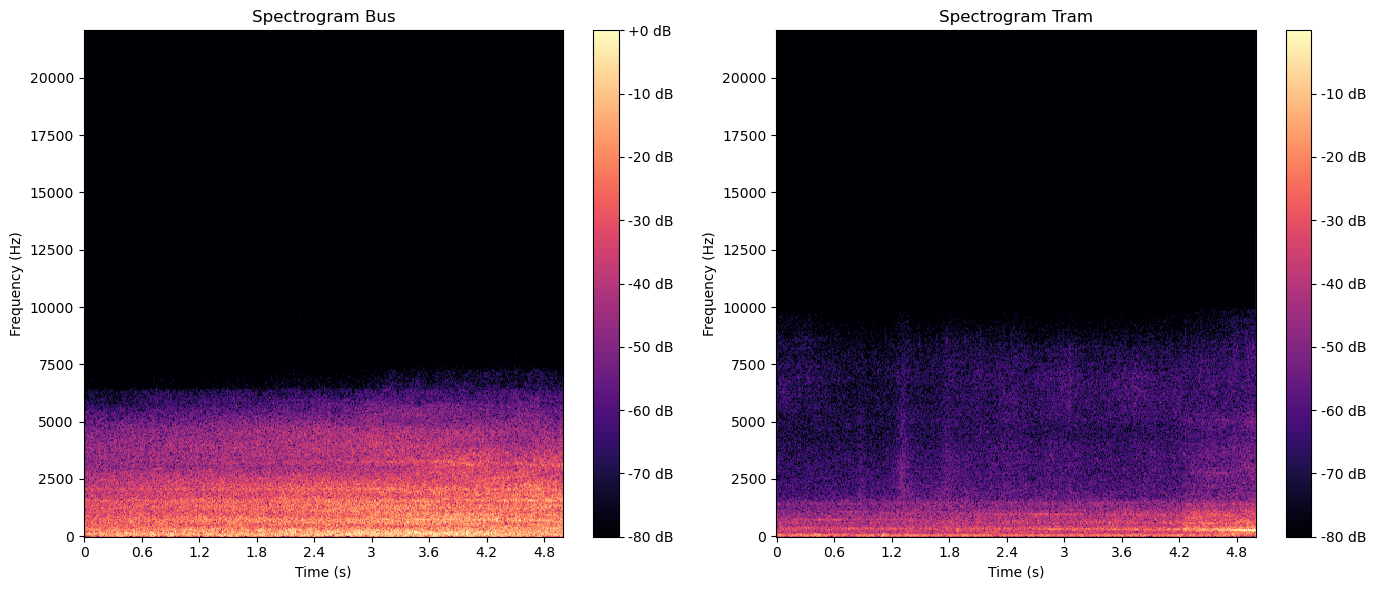

In [14]:
# Plot some spectrogram and compare
def create_spectrogram(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    win_length = n_fft
    hop_length = n_fft//2
    librosa_spectrogram = librosa.stft(y=y,n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    librosa_power_spectrogram = librosa.amplitude_to_db(librosa_spectrogram, ref=np.max)
    return librosa_power_spectrogram, sr


librosa_power_spectrogram1,sr1 = create_spectrogram('./dataset/bus/657981__petrijuhani__bussi2.wav')
librosa_power_spectrogram2,sr2 = create_spectrogram('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa_power_spectrogram1, sr=sr1, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Bus')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa_power_spectrogram2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Tram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

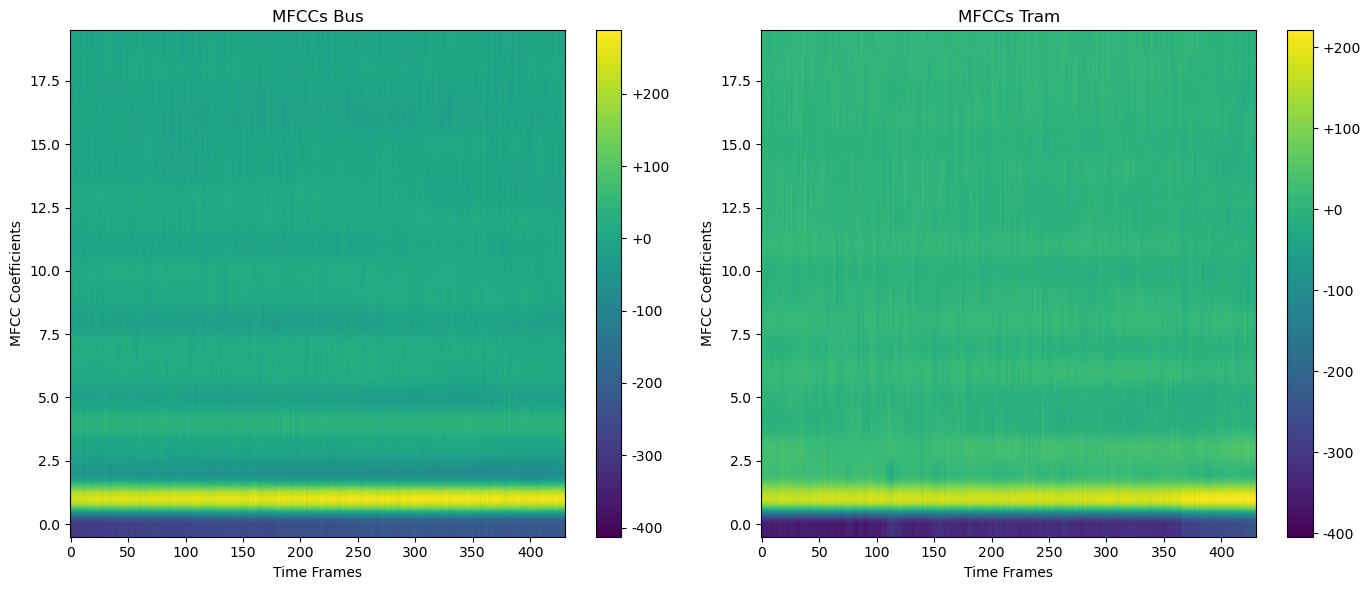

In [15]:
#Plot some mfccs and compare
def create_mfcc(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    hop_length =n_fft//2 
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return mfccs

mfccs1 = create_mfcc('./dataset/bus/657981__petrijuhani__bussi2.wav')
mfccs2 = create_mfcc('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(mfccs1, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Bus")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.subplot(1, 2, 2)
plt.imshow(mfccs2, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Tram")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

In [16]:
create_pngs_from_wavs('./dataset/bus', './Spectogram_images/bus')
create_pngs_from_wavs('./dataset/tram', './Spectogram_images/tram')


In [17]:
def load_images_from_path(path, label):
    images = []
    labels = []
    #transforms.ToTensor() automatically converts and normalizes pixel values to [0.0, 1.0]
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    print(len(os.listdir(path)))

    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)
        images.append(img_tensor)
        labels.append(label)

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
# Tensorflow has default (C,H,W)
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
        ax.imshow(img)

# x is array of images of mel spectrogram
x = []
# y is the array of labels
y = []

157


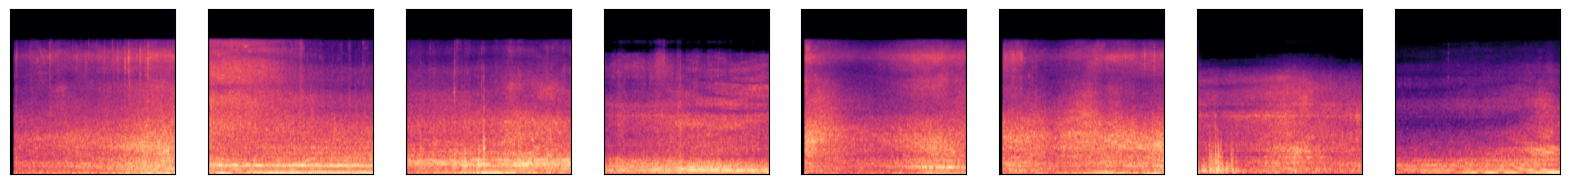

In [18]:
images, labels = load_images_from_path('./Spectogram_images/bus', 0)
x += images
y += labels

show_images(images)

157


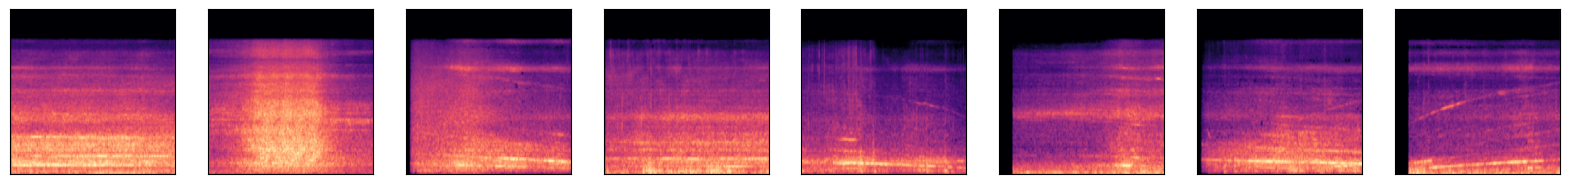

In [19]:
images, labels = load_images_from_path('./Spectogram_images/tram', 1)
x += images
y += labels

show_images(images)

In [20]:
print(f'x size: {len(x)}')
print(f'y size: {len(y)}')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

# Convert to PyTorch tensors
x_train_tensor = torch.stack(x_train)  # Assuming `x` contains tensors of shape (C, H, W)
x_test_tensor = torch.stack(x_test)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define a DataLoader for training and testing sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify sizes
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Testing set size: {len(test_loader.dataset)}')
print(images[0].size())

x size: 314
y size: 314
Training set size: 251
Testing set size: 63
torch.Size([3, 224, 224])


In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), #(224+2×1−3)/1 +1 = (32, 224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (32, 112,112)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (112+2×1−3)/1 +1 = (64, 112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (64, 56,56)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # (56+2×1−3)/1 +1 = (128, 56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (128, 28,28)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # (28+2×1−3)/1 +1 = (128, 28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (128, 14,14)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128*14*14, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=2)
        self.output = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)  # Flatten feature maps into a 1D vector
        x = self.fc1(x) 
        x = self.fc2(x) 
        x = self.output(x)  # Apply softmax for classification
        
        return x
model=CNNModel()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]         147,584
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
          Flatten-13                [-1, 25088]               0
           Linear-14                 [-

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
start_time = time.time()
for epoch in range(10):
    print(f'Training epoch {epoch}....')

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    model.train()

    for i,data in enumerate(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        
        # calculate loss
        prediction = model(inputs)
        loss = loss_fn(prediction, targets)
        # backpropagate error and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # predicted = torch.argmax(predictions, dim=1)  # Get the index of the max logit
        # correct_predictions += (predicted == targets).sum().item()
        # total_samples += targets.size(0)

        running_loss += loss.item()
    # epoch_loss = running_loss / len(train_loader)
    # epoch_accuracy = correct_predictions / total_samples
    # TODO: plot loss and accuracy progress but need 320 sample
    print(f"loss : {running_loss/ len(train_loader):.4f}")
end_time = time.time()

total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")

Training epoch 0....
loss : 0.8148
Training epoch 1....
loss : 0.8177
Training epoch 2....
loss : 0.8131
Training epoch 3....
loss : 0.7160
Training epoch 4....
loss : 0.6974
Training epoch 5....
loss : 0.6974
Training epoch 6....
loss : 0.6922
Training epoch 7....
loss : 0.6865
Training epoch 8....
loss : 0.6404
Training epoch 9....
loss : 0.5254
Total Training Time: 84.06 seconds


In [24]:
torch.save(model.state_dict(), 'vehicle-audio-processing-model.pth')

In [25]:
#Load model
model = CNNModel()
model.load_state_dict(torch.load('vehicle-audio-processing-model.pth'))

/var/folders/ty/4_flnrx15gsf9bd6jh4ypbtw0000gp/T/ipykernel_2363/383356240.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vehicle-audio

<All keys matched successfully>

In [26]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        predictions = model(inputs)
        _, predicted = torch.max(predictions,1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()


accuracy = 100 * correct/total
print(f'Accuracy: {accuracy}% ')

Accuracy: 65.07936507936508% 
